In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/EnergyConsumptionPrediction

/content/drive/MyDrive/Colab Notebooks/EnergyConsumptionPrediction


In [4]:
!apt-get install -y p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [29]:
!mkdir data/REFIT_CLEAN

In [5]:
!rm data/REFIT_CLEAN/*.csv

In [6]:
!7z x CLEAN_REFIT_081116.7z -odata/REFIT_CLEAN


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 514265481 bytes (491 MiB)

Extracting archive: CLEAN_REFIT_081116.7z
--
Path = CLEAN_REFIT_081116.7z
Type = 7z
Physical Size = 514265481
Headers Size = 522
Method = LZMA:26
Solid = +
Blocks = 2

  0%      0% - CLEAN_House1.csv                         1% - CLEAN_House1.csv                         2% - CLEAN_House1.csv                         3% - CLEAN_House1.csv                         4% - CLEAN_House1.csv                         5% - CLEAN_House1.csv        

In [7]:
!ls data/REFIT_CLEAN

CLEAN_House10.csv  CLEAN_House16.csv  CLEAN_House20.csv  CLEAN_House5.csv
CLEAN_House11.csv  CLEAN_House17.csv  CLEAN_House21.csv  CLEAN_House6.csv
CLEAN_House12.csv  CLEAN_House18.csv  CLEAN_House2.csv	 CLEAN_House7.csv
CLEAN_House13.csv  CLEAN_House19.csv  CLEAN_House3.csv	 CLEAN_House8.csv
CLEAN_House15.csv  CLEAN_House1.csv   CLEAN_House4.csv	 CLEAN_House9.csv


# ## 1. Install & Import Dependencies

In [8]:
!pip install dask[complete] scikit-learn schedule watchdog joblib matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.3 MB/s eta 0:00:00


In [9]:
import os, time, logging, json
from pathlib import Path
import pandas as pd
import numpy as np
import dask.dataframe as dd
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import joblib, schedule
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings

# Set up logging

In [10]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names")

## 2. Configuration

In [11]:
DATA_DIR   = Path("data/REFIT_CLEAN")
MODEL_DIR  = Path("models"); MODEL_DIR.mkdir(exist_ok=True)
CHUNK_SIZE = 1_900_000  # rows per chunk when using pandas
PEAK_Q     = 0.90       # 90‑percentile threshold for peak detection
FEATURE_BASE = ["hour", "dayofweek", "is_weekend"]
APPLIANCE_COLS = [f"Appliance{i}" for i in range(1,10)]

# ## 3. Utility Functions

In [12]:
def read_chunked(path: Path, chunksize: int = CHUNK_SIZE):
    """Lazy‑load CSV in manageable pieces."""
    num_cols = {c: np.float32 for c in APPLIANCE_COLS + ["Aggregate"]}
    for chunk in pd.read_csv(path,
                             parse_dates=["Time"],
                             usecols=lambda c: c != "Issues",  # drop Issues col
                             dtype=num_cols,
                             chunksize=chunksize):
        yield chunk

In [13]:
def clean_chunk(df: pd.DataFrame) -> pd.DataFrame:
    """Apply standard cleaning steps consistently."""
    df = df.drop_duplicates(subset=["Unix"]).copy()
    df.fillna(method="ffill", inplace=True)
    return df

In [14]:
sample_files = sorted(DATA_DIR.glob("CLEAN_House*.csv"))[:3]

In [15]:
for file in sample_files:
    print(f"\n📁 File: {file.name}")
    raw_chunk = next(read_chunked(file, chunksize=25))
    print("🔹 Head BEFORE cleaning:")
    display(raw_chunk.head())

    cleaned_chunk = clean_chunk(raw_chunk)
    print("🔸 Head AFTER cleaning:")
    display(cleaned_chunk.head())


📁 File: CLEAN_House1.csv
🔹 Head BEFORE cleaning:


,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
0,2013-10-09 13:06:17,1381323977,523.0,74.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2013-10-09 13:06:31,1381323991,526.0,75.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2013-10-09 13:06:46,1381324006,540.0,74.0,0.0,68.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2013-10-09 13:07:01,1381324021,532.0,74.0,0.0,68.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2013-10-09 13:07:15,1381324035,540.0,74.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,1.0


🔸 Head AFTER cleaning:


,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
0,2013-10-09 13:06:17,1381323977,523.0,74.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2013-10-09 13:06:31,1381323991,526.0,75.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2013-10-09 13:06:46,1381324006,540.0,74.0,0.0,68.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2013-10-09 13:07:01,1381324021,532.0,74.0,0.0,68.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2013-10-09 13:07:15,1381324035,540.0,74.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,1.0



📁 File: CLEAN_House10.csv
🔹 Head BEFORE cleaning:


,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
0,2013-11-20 11:31:18,1384947078,3078.0,0.0,70.0,0.0,0.0,0.0,2.0,25.0,0.0,0.0
1,2013-11-20 11:31:31,1384947091,3078.0,0.0,70.0,0.0,0.0,0.0,1.0,25.0,0.0,0.0
2,2013-11-20 11:31:45,1384947105,215.0,0.0,69.0,0.0,0.0,0.0,1.0,25.0,0.0,0.0
3,2013-11-20 11:31:58,1384947118,212.0,0.0,71.0,0.0,0.0,0.0,2.0,25.0,0.0,0.0
4,2013-11-20 11:32:18,1384947138,213.0,0.0,70.0,0.0,0.0,0.0,2.0,25.0,0.0,0.0


🔸 Head AFTER cleaning:


,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
0,2013-11-20 11:31:18,1384947078,3078.0,0.0,70.0,0.0,0.0,0.0,2.0,25.0,0.0,0.0
1,2013-11-20 11:31:31,1384947091,3078.0,0.0,70.0,0.0,0.0,0.0,1.0,25.0,0.0,0.0
2,2013-11-20 11:31:45,1384947105,215.0,0.0,69.0,0.0,0.0,0.0,1.0,25.0,0.0,0.0
3,2013-11-20 11:31:58,1384947118,212.0,0.0,71.0,0.0,0.0,0.0,2.0,25.0,0.0,0.0
4,2013-11-20 11:32:18,1384947138,213.0,0.0,70.0,0.0,0.0,0.0,2.0,25.0,0.0,0.0



📁 File: CLEAN_House11.csv
🔹 Head BEFORE cleaning:


,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
0,2014-06-03 11:36:21,1401795381,1777.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11.0,21.0
1,2014-06-03 11:37:21,1401795441,1385.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,10.0,20.0
2,2014-06-03 11:37:37,1401795457,1298.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,10.0,20.0
3,2014-06-03 11:37:53,1401795473,1252.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,20.0
4,2014-06-03 11:38:08,1401795488,1256.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11.0,20.0


🔸 Head AFTER cleaning:


,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
0,2014-06-03 11:36:21,1401795381,1777.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11.0,21.0
1,2014-06-03 11:37:21,1401795441,1385.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,10.0,20.0
2,2014-06-03 11:37:37,1401795457,1298.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,10.0,20.0
3,2014-06-03 11:37:53,1401795473,1252.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,20.0
4,2014-06-03 11:38:08,1401795488,1256.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11.0,20.0


In [16]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour"]       = df["Time"].dt.hour.astype(np.int8)
    df["dayofweek"]  = df["Time"].dt.dayofweek.astype(np.int8)
    df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(np.int8)
    for col in ["Aggregate"] + APPLIANCE_COLS:
        roll = df[col].rolling(window=3, min_periods=1)
        df[f"{col}_roll_mean"] = roll.mean().astype(np.float32)
        df[f"{col}_roll_std"]  = roll.std().fillna(0).astype(np.float32)
    return df

In [17]:
def compute_thresholds_global(sample_rows_per_house: int = 30_000):
    """Collect a small sample from **every** house then compute 90‑percentile thresholds.
    This يمنع التحيّز لبيت واحد ويقلّل مشكلة F1=0/1."""
    frames = []
    for csv in sorted(DATA_DIR.glob("CLEAN_House*.csv")):
        try:
            chunk = next(read_chunked(csv, chunksize=sample_rows_per_house))
            frames.append(clean_chunk(chunk))
        except StopIteration:
            pass  # ملف صغير جدًا
    big_sample = pd.concat(frames, ignore_index=True)
    return {c: big_sample[c].quantile(PEAK_Q) for c in APPLIANCE_COLS}

In [18]:
def describe_columns():
    desc = {
        "Time": "Timestamp (corrected for DST)",
        "Unix": "UNIX epoch seconds",
        "Aggregate": "Whole‑house power (W)",
        **{c: f"{c} power (W)" for c in APPLIANCE_COLS},
        "Issues": "1 if ΣIAMs > Aggregate (data quality flag)"
    }
    return pd.DataFrame(desc.items(), columns=["Column", "Meaning"])

In [19]:
def small_preview(files: list[Path], rows: int = 5):
    """Show head() of each file (first *rows* lines)."""
    for p in files:
        chunk = next(read_chunked(p, chunksize=rows))
        chunk = clean_chunk(chunk)
        display(HTML(f"<h4>{p.name}</h4>"))
        display(chunk.head(rows))

# ## 4. Quick Data Peek

# ### 4.1 Exploratory Plots

In [20]:
SAMPLE_PATH = DATA_DIR/"CLEAN_House1.csv"
raw_sample  = clean_chunk(next(read_chunked(SAMPLE_PATH, chunksize=120000)))

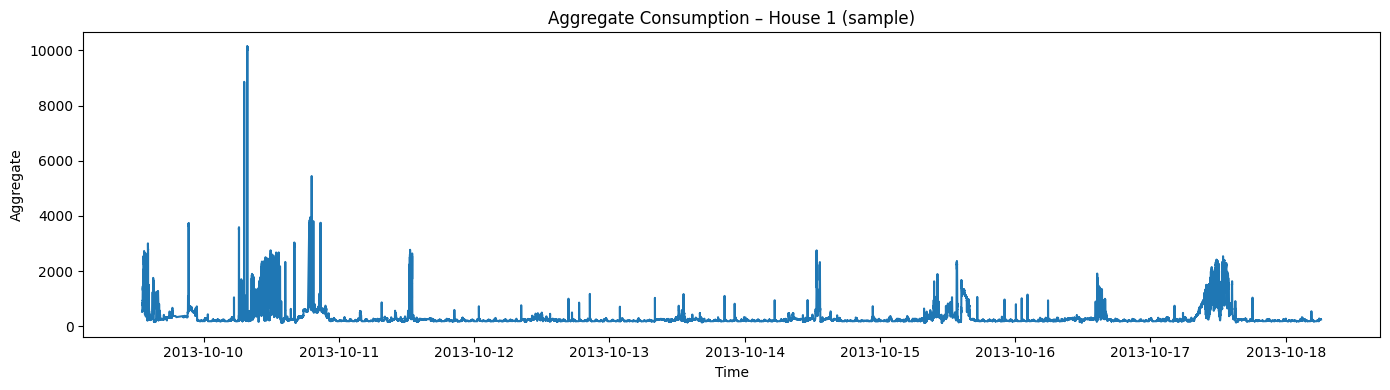

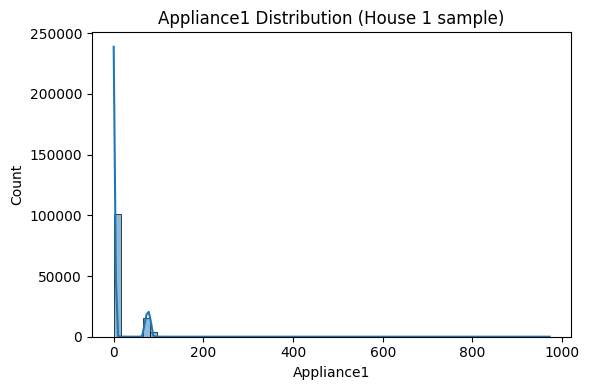

In [21]:
plt.figure(figsize=(14,4))
sns.lineplot(data=raw_sample, x="Time", y="Aggregate")
plt.title("Aggregate Consumption – House 1 (sample)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
sns.histplot(raw_sample["Appliance1"], bins=60, kde=True)
plt.title("Appliance1 Distribution (House 1 sample)")
plt.tight_layout(); plt.show()

# Load and clean small chunks from multiple houses for visualization

In [22]:
multi_samples = []
for file in sample_files:
    try:
        chunk = next(read_chunked(file, chunksize=10_000))
        cleaned = clean_chunk(chunk)
        multi_samples.append(cleaned)
    except StopIteration:
        continue

In [23]:
combined_data = pd.concat(multi_samples, ignore_index=True)

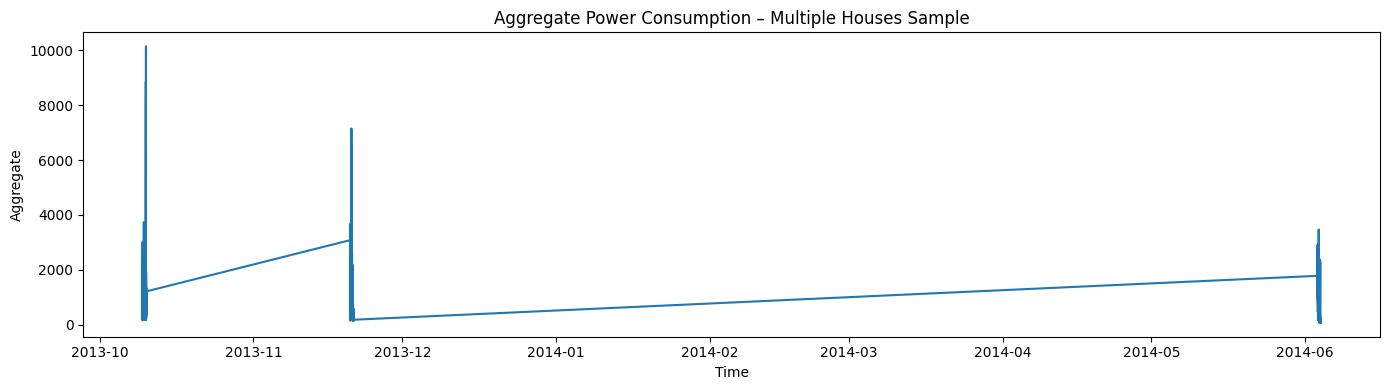

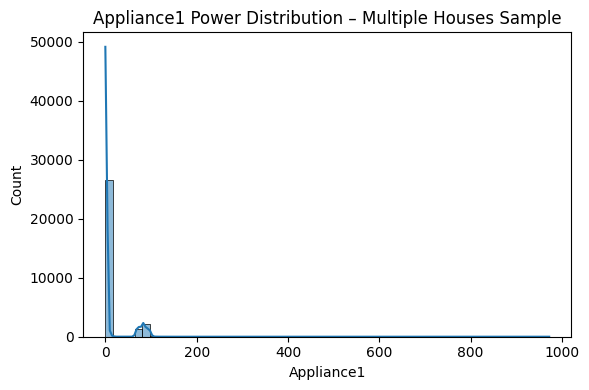

In [24]:
plt.figure(figsize=(14,4))
sns.lineplot(data=combined_data, x="Time", y="Aggregate")
plt.title("Aggregate Power Consumption – Multiple Houses Sample")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(combined_data["Appliance1"], bins=60, kde=True)
plt.title("Appliance1 Power Distribution – Multiple Houses Sample")
plt.tight_layout()
plt.show()

# ## 5. Incremental Model Training

In [25]:
def train_online_models(verbose: bool = True) -> dict:
    """Train SGD online, print per-house F1 if verbose, return final F1 dict."""

    # Global thresholds
    thresh = compute_thresholds_global()
    if verbose:
        logging.info("Thresholds computed → %s", thresh)

    # Prepare global scaler using sample from all houses
    frames = []
    for csv in sorted(DATA_DIR.glob("CLEAN_House*.csv")):
        try:
            chunk = next(read_chunked(csv, chunksize=15_000))
            frames.append(engineer_features(clean_chunk(chunk)))
        except StopIteration:
            continue
    big_sample = pd.concat(frames, ignore_index=True)

    scalers = {}
    for col in APPLIANCE_COLS:
        X_sample = big_sample[FEATURE_BASE + [f"{col}_roll_mean", f"{col}_roll_std"]]
        scaler = StandardScaler().fit(X_sample)
        scalers[col] = scaler

    # Create pipelines with fixed scalers
    pipes = {
        col: Pipeline([
            ("scaler", scalers[col]),
            ("clf", SGDClassifier(loss="log_loss", max_iter=1, tol=None, warm_start=True, random_state=42))
        ]) for col in APPLIANCE_COLS
    }

    classes = np.array([0,1])
    prog_house = []

    # Online training
    for csv in sorted(DATA_DIR.glob("CLEAN_House*.csv")):
        y_true_all, y_pred_all = [], []
        for chunk in read_chunked(csv):
            chunk = clean_chunk(chunk)
            feat  = engineer_features(chunk)
            for col in APPLIANCE_COLS:
                X = feat[FEATURE_BASE + [f"{col}_roll_mean", f"{col}_roll_std"]]
                y = (feat[col] >= thresh[col]).astype(int)

                pipe = pipes[col]
                scaler = pipe.named_steps["scaler"]
                clf = pipe.named_steps["clf"]

                X_scaled = scaler.transform(X)
                clf.partial_fit(X_scaled, y, classes=classes)

                y_hat = clf.predict(X_scaled)
                y_true_all.extend(y)
                y_pred_all.extend(y_hat)

        f1_house = f1_score(y_true_all, y_pred_all, zero_division=0)
        prog_house.append((csv.name, f1_house))
        if verbose:
            logging.info("House %-12s | running F1 = %.3f", csv.name, f1_house)

    # Final evaluation
    f1_scores = {}
    feat_all = engineer_features(big_sample)
    split = int(len(feat_all) * 0.8)
    test = feat_all.iloc[split:]
    for col, pipe in pipes.items():
        joblib.dump(pipe, MODEL_DIR / f"{col}_online.joblib")

        X_t = test[FEATURE_BASE + [f"{col}_roll_mean", f"{col}_roll_std"]]
        y_t = (test[col] >= thresh[col]).astype(int)
        X_t_scaled = pipe.named_steps["scaler"].transform(X_t)
        y_p = pipe.named_steps["clf"].predict(X_t_scaled)
        f1_scores[col] = f1_score(y_t, y_p, zero_division=0)

    json.dump(f1_scores, open(MODEL_DIR / "metrics.json", "w"))

    if verbose:
        logging.info("\n======= Per‑house progress =======")
        for h, f in prog_house:
            logging.info("%s : F1 %.3f", h, f)
        logging.info("==================================\n")

    return f1_scores

# Run training

In [26]:
metrics = train_online_models(verbose=True)
print("Final F1 per appliance:", metrics)

/tmp/ipython-input-12-3432843867.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  for chunk in pd.read_csv(path,


Final F1 per appliance: {'Appliance1': 0.9740030287733468, 'Appliance2': 0.010650887573964497, 'Appliance3': 0.45, 'Appliance4': 0.5986602526637594, 'Appliance5': 0.5080276620698022, 'Appliance6': 0.6002055498458376, 'Appliance7': 0.7409290501502196, 'Appliance8': 0.9430379746835443, 'Appliance9': 0.09547169811320755}


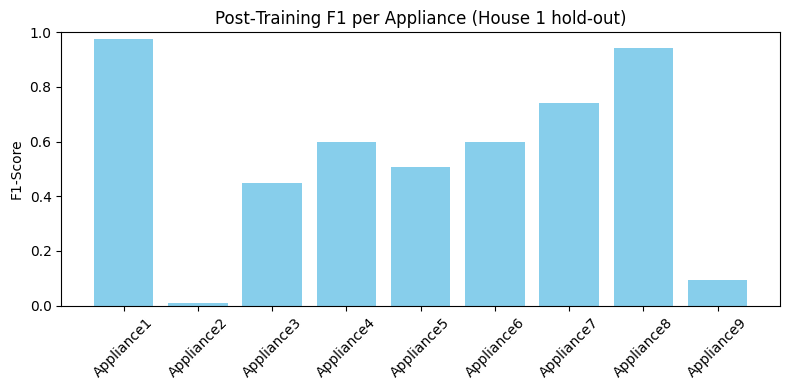

In [27]:
plt.figure(figsize=(8,4))
appls, scores = zip(*sorted(metrics.items()))
plt.bar(appls, scores, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("F1‑Score")
plt.ylim(0, 1)
plt.title("Post‑Training F1 per Appliance (House 1 hold‑out)")
plt.tight_layout()
plt.show()

In [28]:
# Sort appliances by F1 score descending
sorted_metrics = sorted(metrics.items(), key=lambda x: x[1], reverse=True)

print("\n📋 Summary of model performance per appliance (F1-score):")
for appliance, score in sorted_metrics:
    if score >= 0.7:
        status = "✅ High accuracy"
    elif score >= 0.4:
        status = "⚠️ Medium accuracy"
    else:
        status = "❌ Low accuracy"
    print(f"{appliance:<12} : F1-score = {score:.3f} → {status}")


📋 Summary of model performance per appliance (F1-score):
Appliance1   : F1-score = 0.974 → ✅ High accuracy
Appliance8   : F1-score = 0.943 → ✅ High accuracy
Appliance7   : F1-score = 0.741 → ✅ High accuracy
Appliance6   : F1-score = 0.600 → ⚠️ Medium accuracy
Appliance4   : F1-score = 0.599 → ⚠️ Medium accuracy
Appliance5   : F1-score = 0.508 → ⚠️ Medium accuracy
Appliance3   : F1-score = 0.450 → ⚠️ Medium accuracy
Appliance9   : F1-score = 0.095 → ❌ Low accuracy
Appliance2   : F1-score = 0.011 → ❌ Low accuracy


# ### 5.1 Evaluation Chart

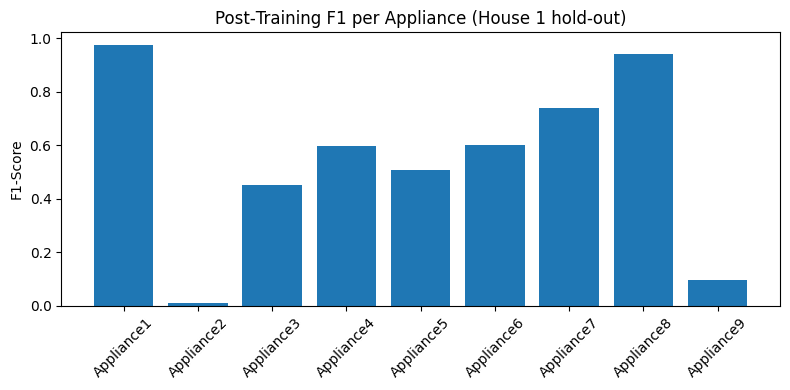

In [29]:
plt.figure(figsize=(8,4))
appls, scores = zip(*sorted(metrics.items()))
plt.bar(appls, scores)
plt.xticks(rotation=45)
plt.ylabel("F1‑Score")
plt.title("Post‑Training F1 per Appliance (House 1 hold‑out)")
plt.tight_layout(); plt.show()

# ## 6. Real‑Time Monitoring & Control (Prototype)

In [30]:
def predict_action(latest_feat: pd.Series, appliance: str) -> str:
    pipe = joblib.load(MODEL_DIR / f"{appliance}_online.joblib")
    X = latest_feat[FEATURE_BASE + [f"{appliance}_roll_mean", f"{appliance}_roll_std"]].to_frame().T
    pred = pipe.predict(X)[0]  # 1=Peak
    return "OFF" if pred else "ON"

# ## 6. Real-Time Monitoring & Control

In [31]:
def monitor_house(house_id: int, poll_seconds: int = 5):
    csv_path = DATA_DIR / f"CLEAN_House{house_id}.csv"
    logging.info("Starting real‑time monitor for House%s", house_id)

    # احفظ حجم الملف، وبعدها كل دورة نقرأ فقط ما استجد
    last_pos = os.path.getsize(csv_path)

    while True:
        current_size = os.path.getsize(csv_path)
        if current_size > last_pos:
            with open(csv_path, 'r') as f:
                f.seek(last_pos)
                new_lines = f.readlines()
            last_pos = current_size

            if new_lines:
                df_new = pd.read_csv(pd.compat.StringIO(''.join(new_lines)), names=raw_sample.columns)
                df_new = clean_chunk(df_new)
                feat    = engineer_features(df_new).iloc[-1]  # latest row only

                for col in APPLIANCE_COLS:
                    action = predict_action(feat, col)
                    logging.info("House%s | %s ⇒ %s", house_id, col, action)
        time.sleep(poll_seconds)

# ## 7. Scheduler Example (House 1 every minute)

# Uncomment to activate real‑time loop inside notebook (blocking)

In [32]:
MODEL_DIR = Path("models")
DATA_DIR  = Path("data/REFIT_CLEAN")
df = pd.read_csv(DATA_DIR / "CLEAN_House1.csv", parse_dates=["Time"]).tail(1)
feat = engineer_features(df).iloc[-1]

In [33]:
for col in APPLIANCE_COLS:
    action = predict_action(feat, col)
    print(col, "→", action)

Appliance1 → ON
Appliance2 → ON
Appliance3 → ON
Appliance4 → ON
Appliance5 → ON
Appliance6 → ON
Appliance7 → ON
Appliance8 → ON
Appliance9 → ON


In [34]:
def evaluate_houses(house_ids: list[int], sample_rows: int = 200_000):
    """Return mean F1 across chosen houses (uses existing trained models)."""
    all_y, all_p = {c: [] for c in APPLIANCE_COLS}, {c: [] for c in APPLIANCE_COLS}
    thresh = compute_thresholds_global()
    for hid in house_ids:
        csv = DATA_DIR / f"CLEAN_House{hid}.csv"
        if not csv.exists():
            logging.warning("File %s not found; skipping", csv)
            continue
        df = clean_chunk(next(read_chunked(csv, chunksize=sample_rows)))
        feat = engineer_features(df)
        for col in APPLIANCE_COLS:
            mdl = joblib.load(MODEL_DIR / f"{col}_online.joblib")
            X = feat[FEATURE_BASE + [f"{col}_roll_mean", f"{col}_roll_std"]]
            y = (feat[col] >= thresh[col]).astype(int)
            p = mdl.predict(X)
            all_y[col].extend(y)
            all_p[col].extend(p)
    return {col: f1_score(all_y[col], all_p[col], zero_division=0) for col in APPLIANCE_COLS}

In [35]:
first4 = [int(p.stem.split('House')[-1]) for p in sorted(DATA_DIR.glob('CLEAN_House*.csv'))[:4]]
metrics4 = evaluate_houses(first4, sample_rows=20_000)
print("F1 on houses", first4, "→", metrics4)

F1 on houses [1, 10, 11, 12] → {'Appliance1': 0.060082304526748974, 'Appliance2': 0.9019706922688226, 'Appliance3': 0.26220722508932115, 'Appliance4': 0.9823646299056135, 'Appliance5': 0.9108985653158822, 'Appliance6': 0.9798530457454373, 'Appliance7': 0.9724103082364831, 'Appliance8': 0.4534924534924535, 'Appliance9': 0.0}


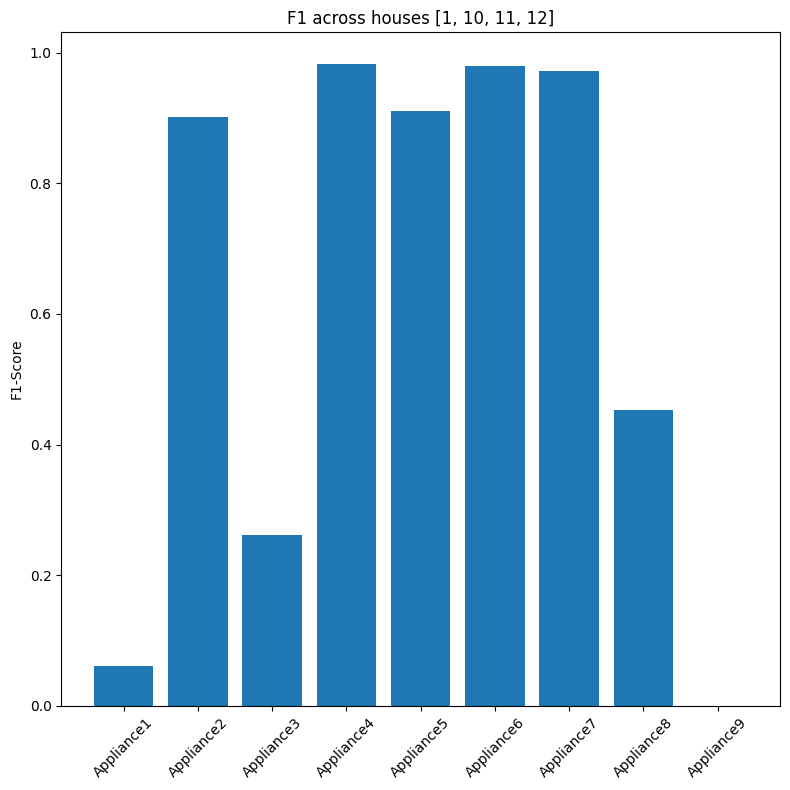

In [36]:
plt.figure(figsize=(8,8))
plt.bar(metrics4.keys(), metrics4.values())
plt.xticks(rotation=45)
plt.ylabel("F1‑Score")
plt.title(f"F1 across houses {first4}")
plt.tight_layout(); plt.show()

In [37]:
def evaluate_single_house(house_id: int, sample_rows: int = 50_000):
    """Return F1 dict for a single house and plot bar chart."""
    csv = DATA_DIR / f"CLEAN_House{house_id}.csv"
    if not csv.exists():
        raise FileNotFoundError(csv)

    df  = clean_chunk(next(read_chunked(csv, chunksize=sample_rows)))
    feat = engineer_features(df)
    thresh = compute_thresholds_global()

    results = {}
    for col in APPLIANCE_COLS:
        mdl = joblib.load(MODEL_DIR / f"{col}_online.joblib")
        X = feat[FEATURE_BASE + [f"{col}_roll_mean", f"{col}_roll_std"]]
        y = (feat[col] >= thresh[col]).astype(int)
        p = mdl.predict(X)
        results[col] = f1_score(y, p, zero_division=0)

    # Plot
    plt.figure(figsize=(8,3))
    plt.bar(results.keys(), results.values())
    plt.xticks(rotation=45)
    plt.ylabel("F1‑Score")
    plt.title(f"F1 – House {house_id}")
    plt.tight_layout(); plt.show()
    return results

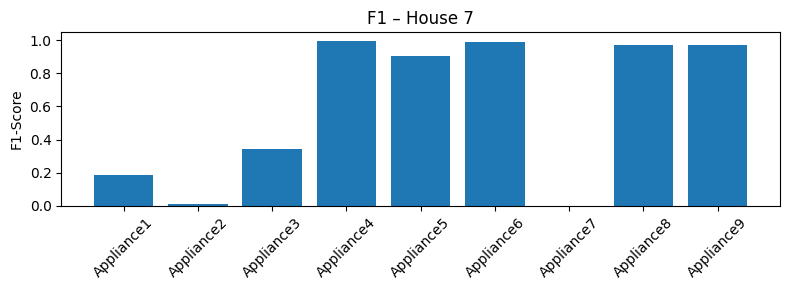

{'Appliance1': 0.18604651162790697, 'Appliance2': 0.00832880680789426, 'Appliance3': 0.34285714285714286, 'Appliance4': 0.9982499124956248, 'Appliance5': 0.9030108588351431, 'Appliance6': 0.9869264291207382, 'Appliance7': 0.0, 'Appliance8': 0.9734513274336283, 'Appliance9': 0.9743589743589743}


In [38]:
house5_metrics = evaluate_single_house(7)
print(house5_metrics)

In [39]:
def alert_high_consumption(df, power_threshold=200, energy_threshold_wh=1000):
    """
    Check appliances for high instantaneous power consumption and high total energy consumption.

    Parameters:
    - df: pandas DataFrame with appliance power data and a datetime 'Time' column.
    - power_threshold: float, instantaneous power threshold in Watts.
    - energy_threshold_wh: float, estimated total energy consumption threshold in Watt-hours.

    Behavior:
    - Prints alerts if any appliance exceeds the instantaneous power threshold.
    - Estimates energy consumption (Watt-hours) per appliance over the time period,
      and prints alerts if it exceeds energy_threshold_wh.
    """
    alerts = []

    # Calculate the duration between measurements in hours (assumes regular intervals)
    time_deltas = df['Time'].diff().dt.total_seconds().dropna()
    if len(time_deltas) == 0:
        print("Insufficient time data to estimate energy consumption.")
        return
    avg_delta_hours = time_deltas.mean() / 3600  # convert seconds to hours

    for appliance in APPLIANCE_COLS:
        max_power = df[appliance].max()
        if max_power > power_threshold:
            alerts.append(f"⚠️ Instantaneous power alert: {appliance} reached {max_power:.2f} W, exceeding threshold of {power_threshold} W.")

        # Estimate total energy consumption in Watt-hours (Wh)
        total_energy = df[appliance].sum() * avg_delta_hours  # sum of Watts * hours
        if total_energy > energy_threshold_wh:
            alerts.append(f"⚠️ Energy consumption alert: {appliance} consumed approximately {total_energy:.1f} Wh, exceeding threshold of {energy_threshold_wh} Wh.")

    if alerts:
        for alert in alerts:
            print(alert)
    else:
        print("All appliances are within safe consumption limits.")

# Example usage after loading and cleaning data:
sample_data = clean_chunk(next(read_chunked(SAMPLE_PATH, chunksize=120000)))
alert_high_consumption(sample_data, power_threshold=200, energy_threshold_wh=1000)


⚠️ Instantaneous power alert: Appliance1 reached 972.00 W, exceeding threshold of 200 W.
⚠️ Energy consumption alert: Appliance1 consumed approximately 2538.8 Wh, exceeding threshold of 1000 Wh.
⚠️ Instantaneous power alert: Appliance2 reached 960.00 W, exceeding threshold of 200 W.
⚠️ Energy consumption alert: Appliance2 consumed approximately 3147.9 Wh, exceeding threshold of 1000 Wh.
⚠️ Instantaneous power alert: Appliance3 reached 1024.00 W, exceeding threshold of 200 W.
⚠️ Energy consumption alert: Appliance3 consumed approximately 5346.5 Wh, exceeding threshold of 1000 Wh.
⚠️ Instantaneous power alert: Appliance4 reached 2048.00 W, exceeding threshold of 200 W.
⚠️ Instantaneous power alert: Appliance6 reached 2336.00 W, exceeding threshold of 200 W.
